In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
def set_global_style():
    sns.set_theme(style="whitegrid", font="serif", context="notebook")
    custom_palette = sns.color_palette("tab20", 20)
    sns.set_palette(custom_palette)

    plt.rcParams.update({
        "figure.figsize": (12, 8),
        "figure.facecolor": "white",
        "savefig.dpi": 300,
        "savefig.bbox": "tight",
        "savefig.facecolor": "white",
        "font.size": 12,
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
        "legend.title_fontsize": 13,
        "figure.titlesize": 18,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 1,
        "axes.edgecolor": "black",
        "axes.grid": True,
        "grid.alpha": 0.3,
        "grid.linewidth": 0.5,
        "axes.prop_cycle": plt.cycler(color=[
            '#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#7209B7',
            '#0FA3B1', '#B23A48', '#F7B801', '#7A4419', '#3F88C5'
        ]),
        "lines.linewidth": 2,
        "patch.linewidth": 0.5,
        "patch.edgecolor": "#CCCCCC"
    })
    
set_global_style()


# **Psycholinguistic and Emotion-Centric Analysis of Mental Health Text**

# **Problem Definition**

This project explores whether mental health status can be identified from language patterns in social media text. Unlike prior work that mainly focuses on classification accuracy, my emphasis is on interpretability uncovering discriminative linguistic patterns (words, sentiments, psycholinguistic markers) that characterize different disorders. This not only supports better classification but also enhances clinical trust and potential real-world applicability.

In [4]:
df1 = pd.read_csv("/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv")

In [5]:
df1.head()

Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety

In [6]:
df1.drop('Unnamed: 0',axis=1,inplace=True)

In [7]:
df1.head()

statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping, confused mind, restless hear...  Anxiety
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3  I've shifted my focus to something else but I'...  Anxiety
4  I'm restless and restless, it's been a month n...  Anxiety

# **Dataset Understanding**

In [8]:
print("=== BASIC DATASET INFORMATION ===")

print(f"Dataset shape: {df1.shape}")

print(f"\n===== Column names =====\n{df1.columns.tolist()}")

print(f"\n====== Data types =====\n{df1.dtypes} ")

print(f"\n===== Missing values =====\n{df1.isnull().sum()}")

print(f"\n===== Missing percentage =====\n{(df1.isnull().sum()/len(df1))*100}")

print(f"\n===== Duplicate rows =====\n{df1.duplicated().sum()}")

print(f"\n===== Data Description =====\n{df1.describe().T}")

=== BASIC DATASET INFORMATION ===
Dataset shape: (53043, 2)

===== Column names =====
['statement', 'status']

====== Data types =====
statement    object
status       object
dtype: object 

===== Missing values =====
statement    362
status         0
dtype: int64

===== Missing percentage =====
statement    0.682465
status       0.000000
dtype: float64

===== Duplicate rows =====
1944

===== Data Description =====
           count unique                top   freq
statement  52681  51073  what do you mean?     22
status     53043      7             Normal  16351


In [9]:
df1.dropna(inplace=True)

In [10]:
df1.shape

(52681, 2)

In [11]:
df1.drop_duplicates(inplace=True)

In [12]:
df1.shape

(51093, 2)

# **Target Variable Distribution**  

In [13]:
df1.status.value_counts()

status
Normal                  16040
Depression              15094
Suicidal                10644
Anxiety                  3623
Bipolar                  2501
Stress                   2296
Personality disorder      895
Name: count, dtype: int64

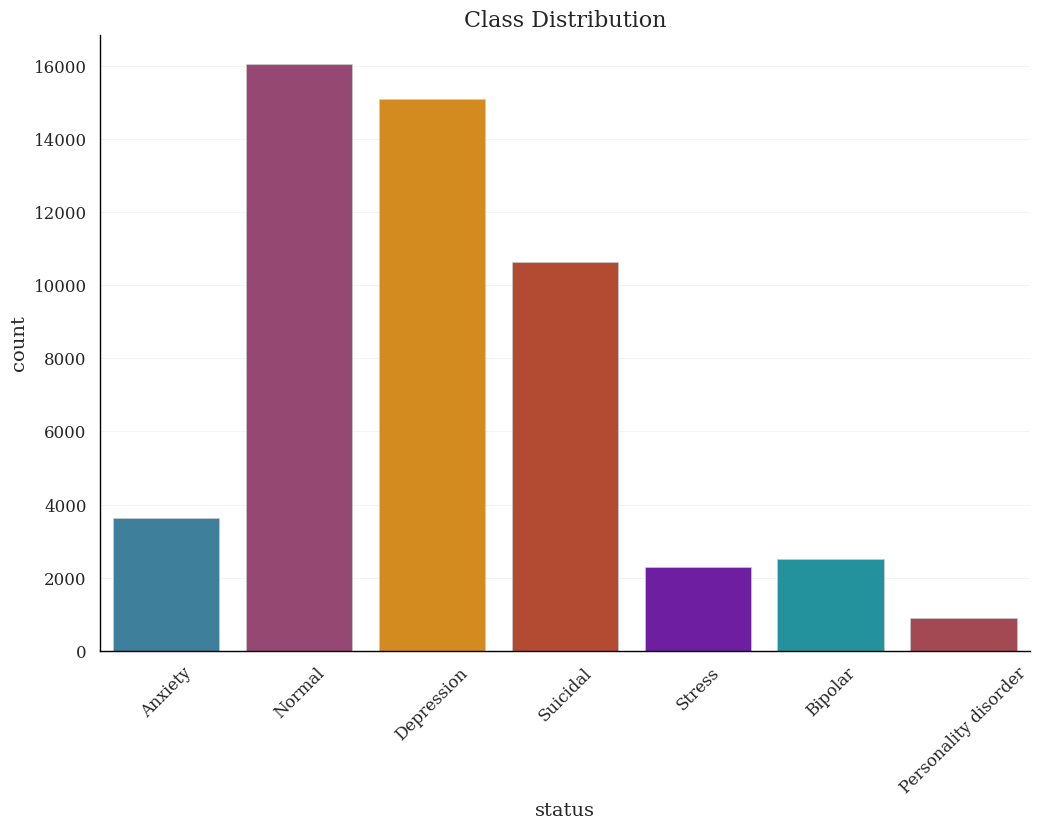

In [14]:
sns.countplot(data=df1,x='status')
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.show()

So, there is class imbalance problem.

# **Data Preprocessing**

### **Outlier Detection and Removal**

In [15]:
# Calculate the length of each statement
df1['statement_length'] = df1['statement'].apply(len)
df1['statement_length'].describe()

count    51093.000000
mean       575.600141
std        847.947705
min          2.000000
25%         79.000000
50%        313.000000
75%        745.000000
max      32759.000000
Name: statement_length, dtype: float64

In [16]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df1['statement_length'].quantile(0.25)
Q3 = df1['statement_length'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

subset = df1[(df1['statement_length'] >= lower_bound) & (df1['statement_length'] <= upper_bound)]

In [17]:
subset.shape

(47647, 3)

The original dataset contains 47647 posts, which is computationally expensive to process for exploratory analysis.

To make the workflow more efficient, I selected a random subset of 2000 posts per status class.

In [18]:
df2 = (subset.groupby("status", group_keys=False).apply(lambda x: x.sample(n=min(len(x), 2000), random_state=42)).reset_index(drop=True))

In [19]:
# df2 = subset.groupby('status', group_keys=False).apply(lambda x: x.sample(frac=20000/len(subset), random_state=42))

In [20]:
df2.shape

(12790, 3)

In [21]:
df2.status.value_counts()

status
Anxiety                 2000
Bipolar                 2000
Depression              2000
Normal                  2000
Stress                  2000
Suicidal                2000
Personality disorder     790
Name: count, dtype: int64

### **Text Data Cleaning by**:

- Expanding contractions

- Converting all text to lowercase

- Removing special characters

- Eliminating extra spaces

- Removing stopwords to focus on meaningful words

- Applying stemming and lemmatization to reduce words to their root forms

In [22]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 4.7 MB/s eta 0:00:00


In [23]:
# for text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer


# For handling contractions
import contractions

In [24]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [25]:
stop_words = set(stopwords.words('english'))

# Remove some words which words are too generic 
domain_stop = set(['like', 'feel', 'know', 'get', 'really', 'one', 'would'])

# Collect label words from dataset so they can be excluded
label_words = set([s.lower() for s in df1['status'].unique()])

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Expand contractions
    text = contractions.fix(text)
    text = text.lower()

    # Keep only letters and spaces
    text = re.sub(r'[^a-z\s]', ' ', text)

    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords, domain fillers, and label words
    tokens = [t for t in tokens if t not in stop_words 
                                and t not in domain_stop 
                                and t not in label_words 
                                and len(t) > 1]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    
    return " ".join(tokens)


In [26]:
df2['clean_statement'] = df2['statement'].astype(str).map(clean_text)

In [27]:
df2.head()

statement   status  \
0  Miradry Experience Miradry Experience\n\nGood ...  Anxiety   
1  I have trouble convincing myself that my frien...  Anxiety   
2  So annoyed with myself...health anxiety resurg...  Anxiety   
3  Health Anxiety Discord https://discord.gg/WSDy...  Anxiety   
4  Anxiety at it again over mice this time. What ...  Anxiety   

   statement_length                                    clean_statement  
0               357  miradry experience miradry experience good mor...  
1               227  trouble convincing friend love brain always te...  
2              1393  annoyed health resurgence hey guy annoyed even...  
3               350  health discord http discord gg wsdyk set expir...  
4              1330  mouse time ease mind health past rabies amoeba...

In [28]:
grouped_statements = df2.groupby("status")["clean_statement"].agg(" ".join)

In [29]:
grouped_statements

status
Anxiety                 miradry experience miradry experience good mor...
Bipolar                 post manic decision love mania man month rough...
Depression              recently moved state mile away home parent eve...
Normal                  decide clicked guy talk therapy specific metho...
Personality disorder    top song alltime hammock sinking inside saved ...
Stress                  relief recently aware stressed tense day long ...
Suicidal                think going kill going use helium place sell h...
Name: clean_statement, dtype: object

# **Exploratory Linguistic Analysis**

### **Word Clouds Visualizations**

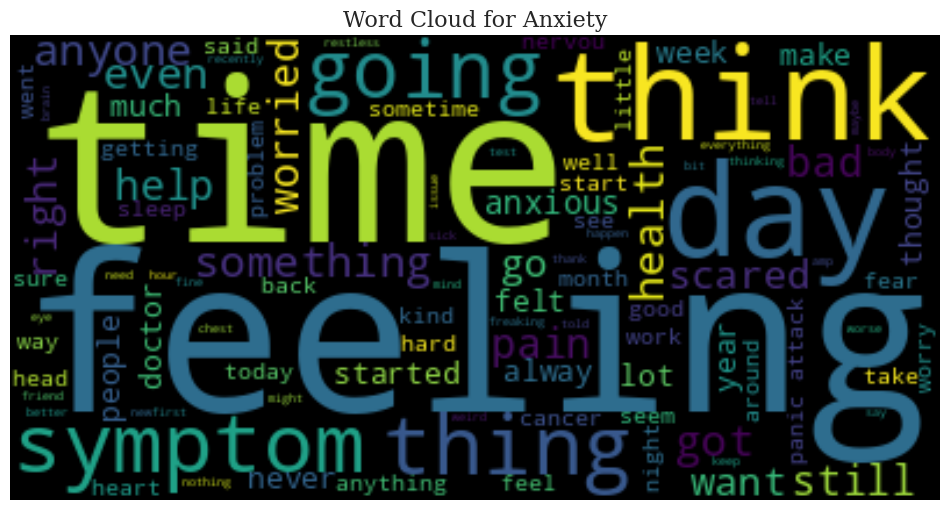

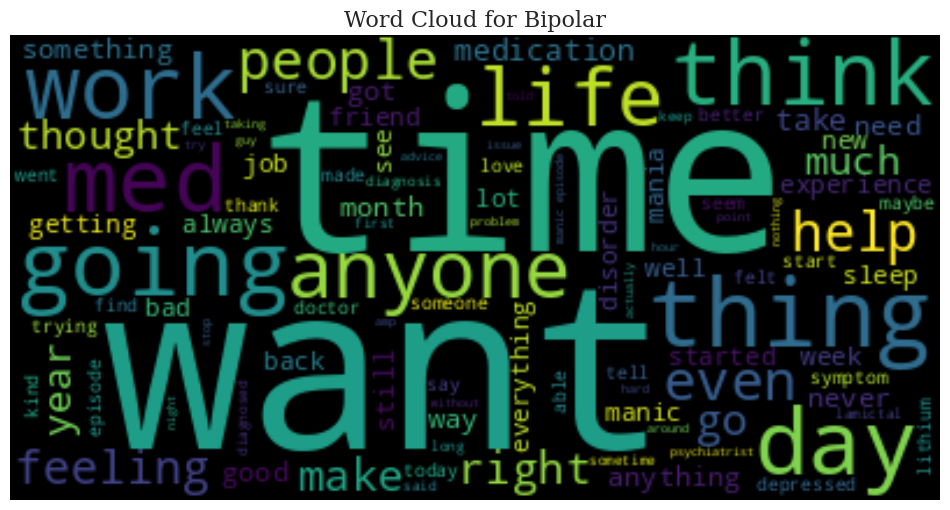

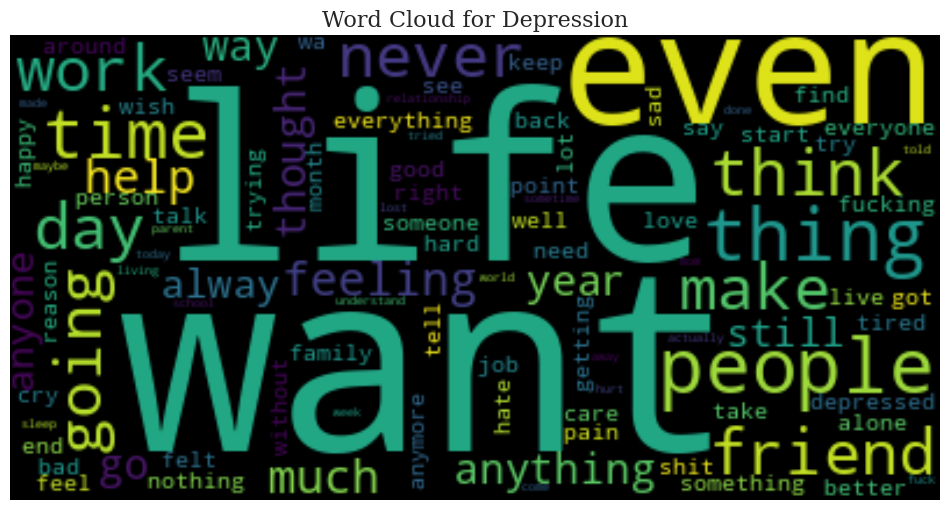

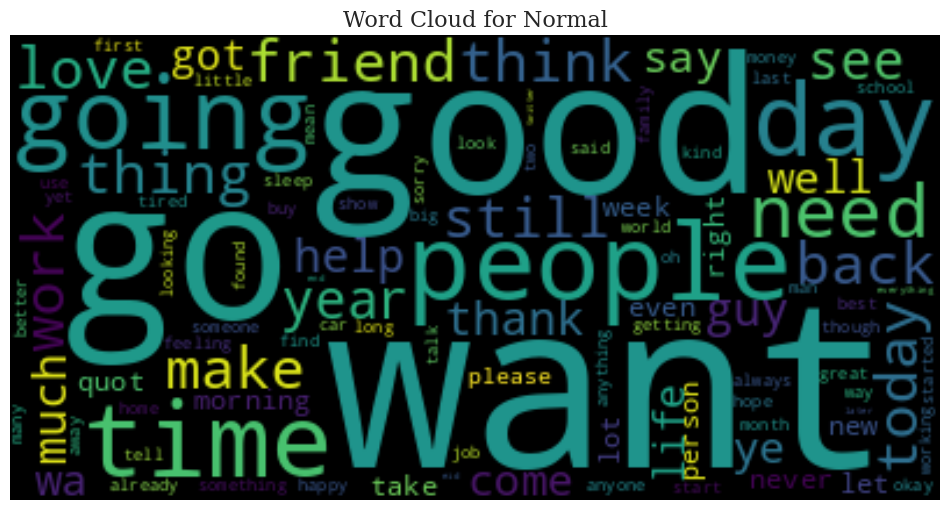

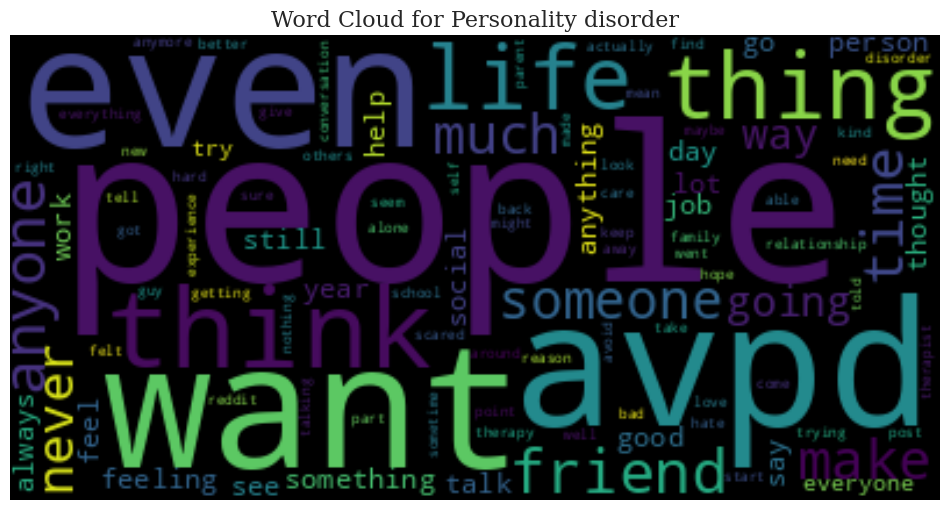

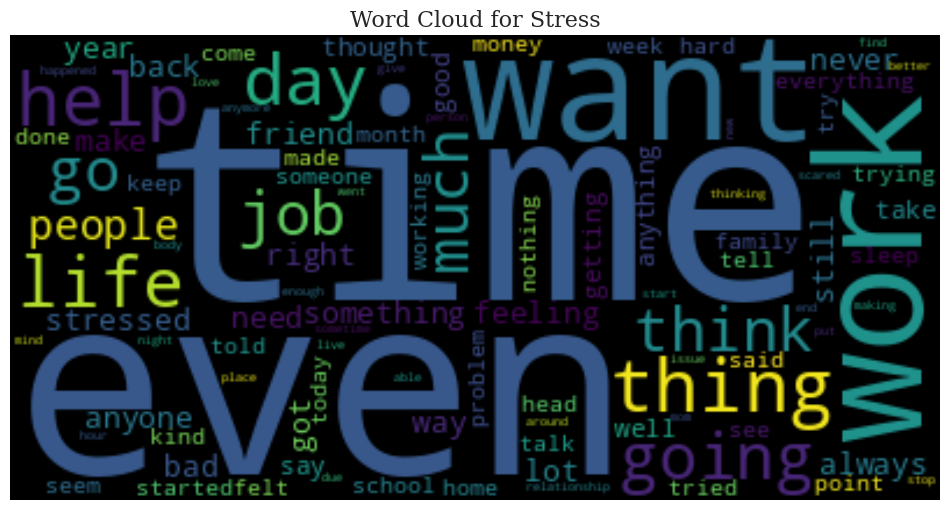

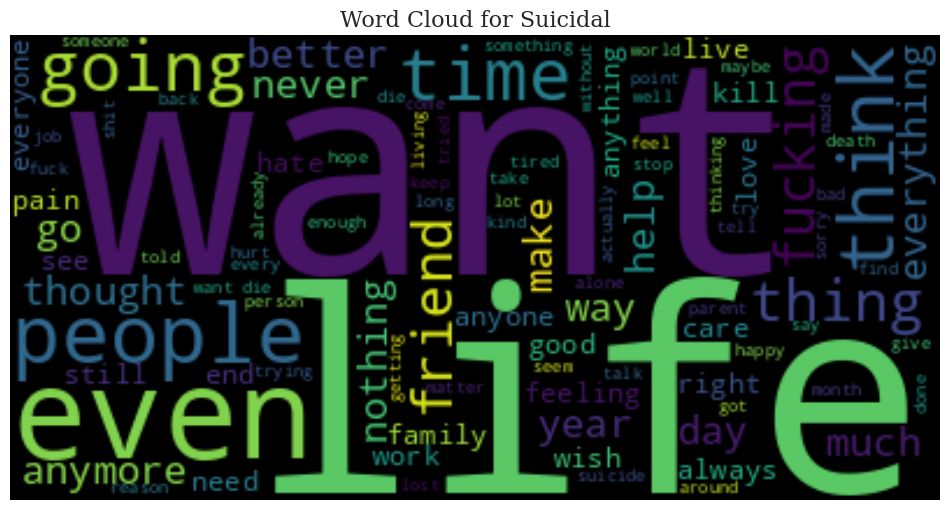

In [30]:
from wordcloud import WordCloud

for status, text in grouped_statements.items():
    wc = WordCloud(max_words=100).generate(text)
    
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {status}")
    plt.show()


### **Most Common Words Analysis**

In [31]:
df2.head()

statement   status  \
0  Miradry Experience Miradry Experience\n\nGood ...  Anxiety   
1  I have trouble convincing myself that my frien...  Anxiety   
2  So annoyed with myself...health anxiety resurg...  Anxiety   
3  Health Anxiety Discord https://discord.gg/WSDy...  Anxiety   
4  Anxiety at it again over mice this time. What ...  Anxiety   

   statement_length                                    clean_statement  
0               357  miradry experience miradry experience good mor...  
1               227  trouble convincing friend love brain always te...  
2              1393  annoyed health resurgence hey guy annoyed even...  
3               350  health discord http discord gg wsdyk set expir...  
4              1330  mouse time ease mind health past rabies amoeba...

In [32]:
df2.shape

(12790, 4)

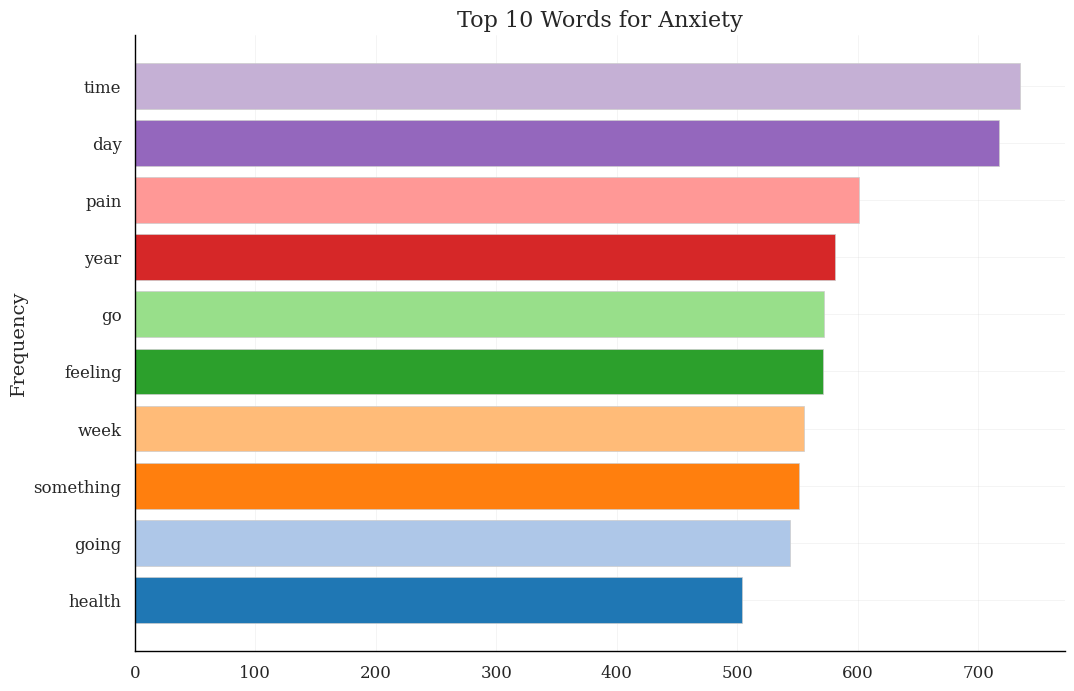

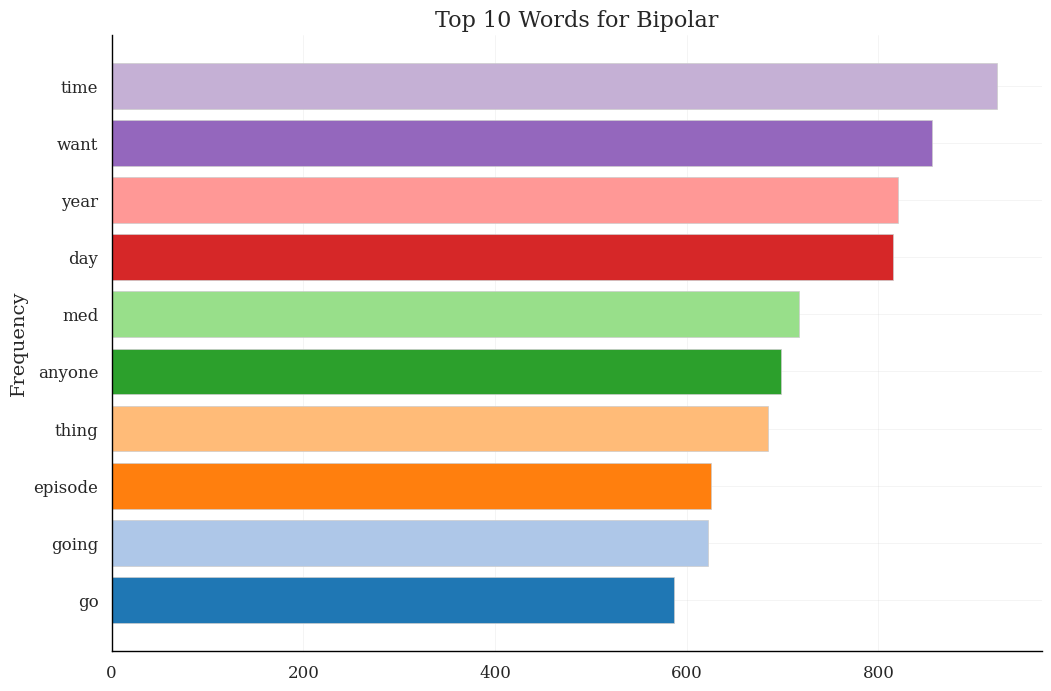

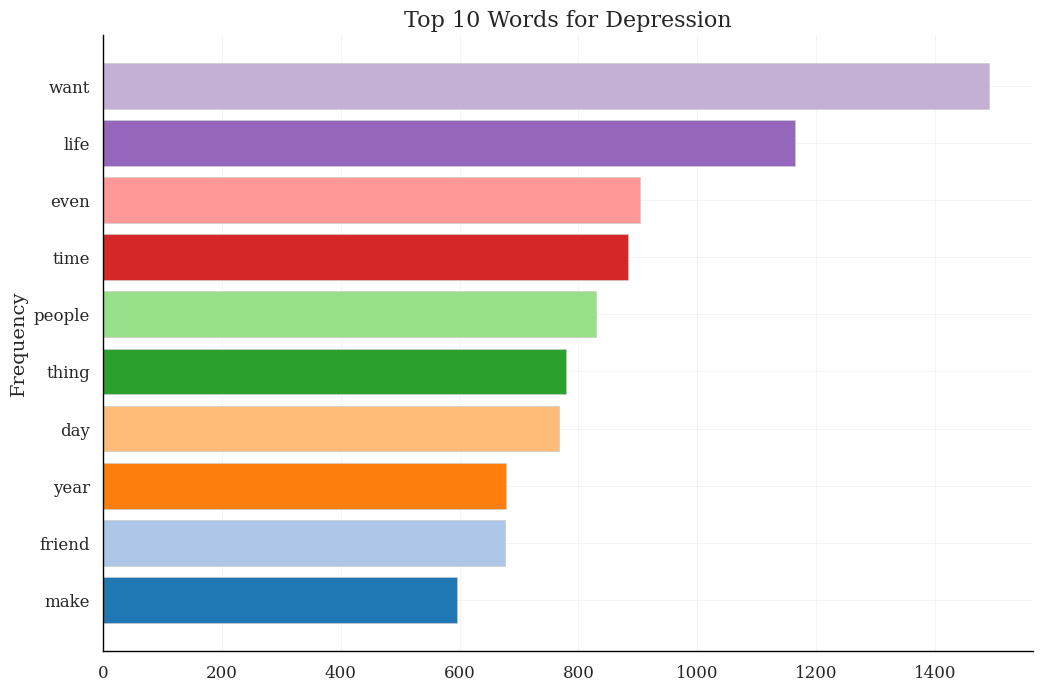

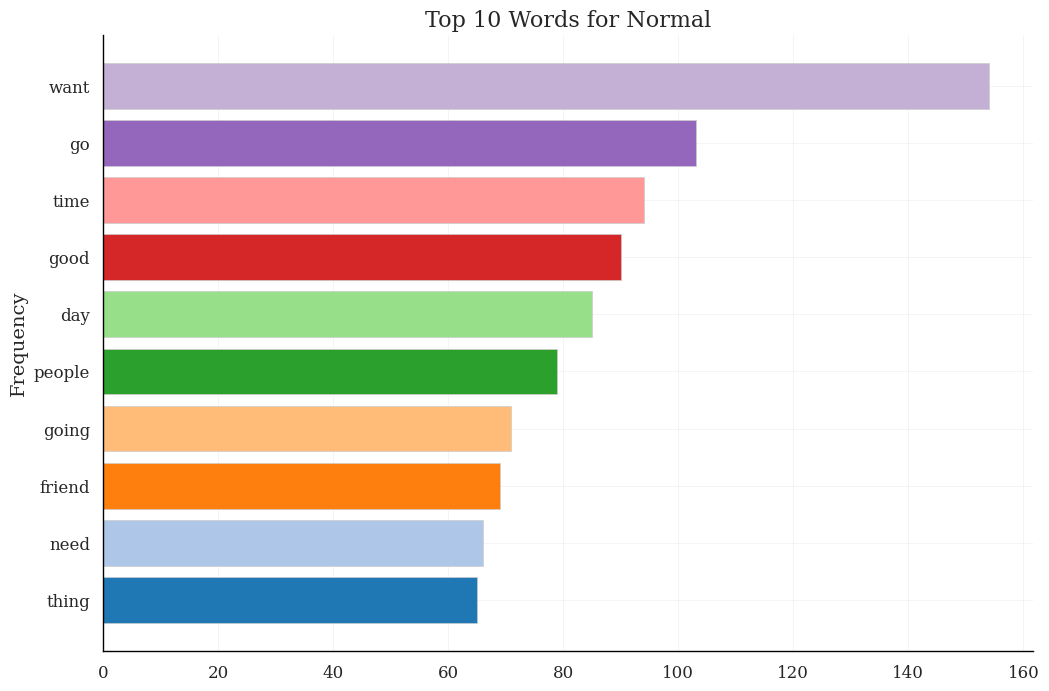

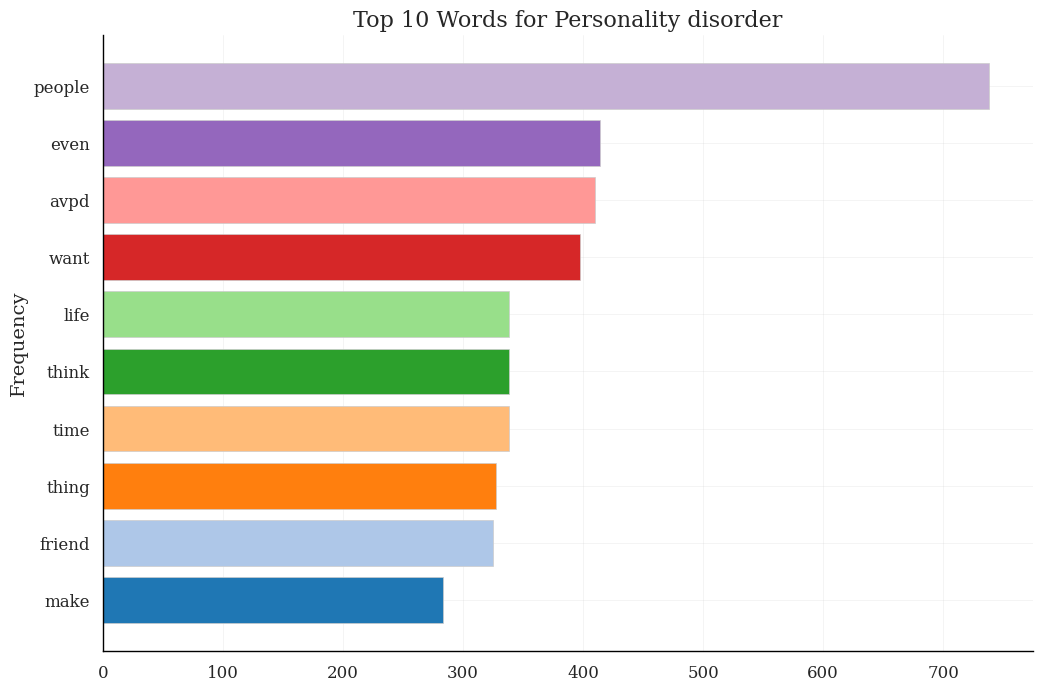

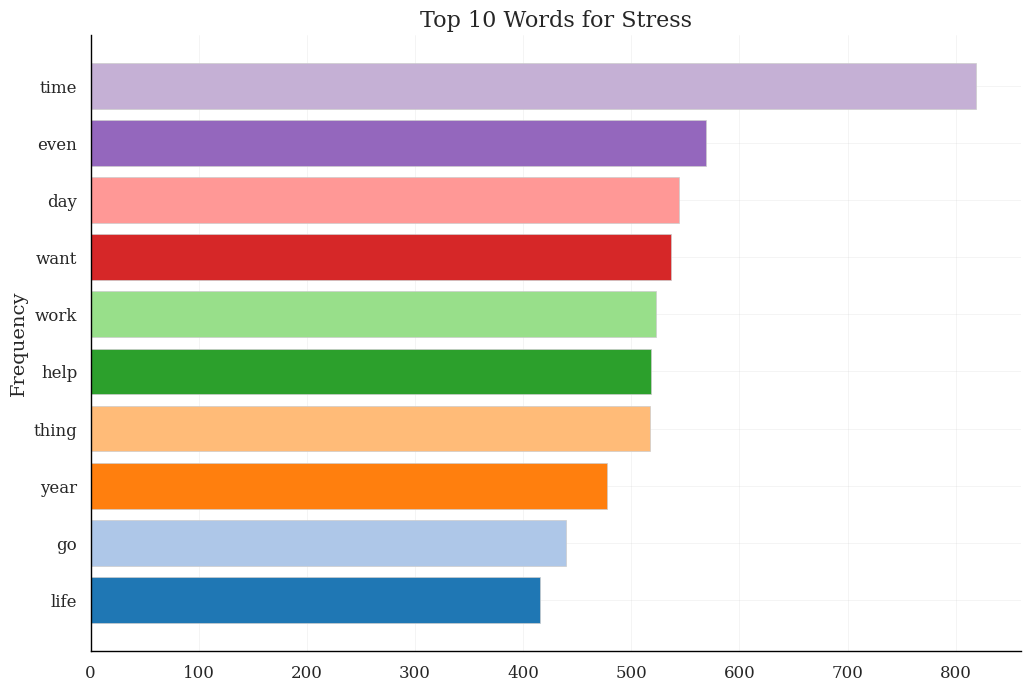

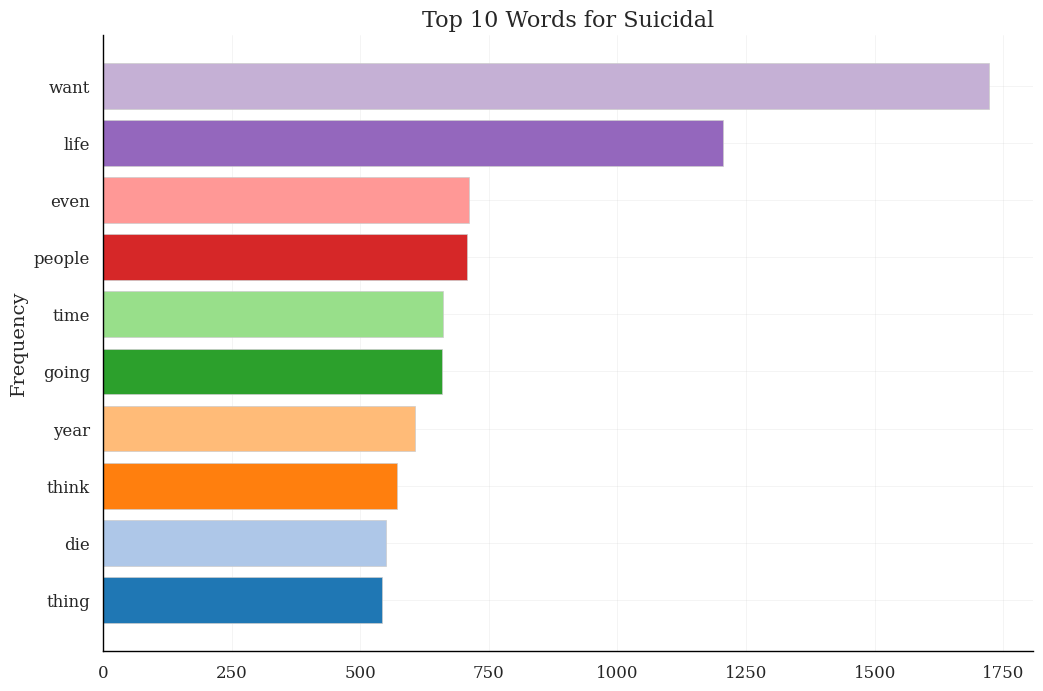

In [33]:
from collections import Counter

for status, text in grouped_statements.items():
    word_freq = Counter(text.split()).most_common(10)
    words, counts = zip(*word_freq)
    words = words[::-1]
    counts = counts[::-1]
    plt.barh(words, counts,color = sns.color_palette("tab20"))
    plt.title(f"Top 10 Words for {status}")
    plt.ylabel("Frequency")
    plt.show()


## **Discriminative keywords Analysis**

Frequency shows the most common words in each class but many of these words appear everywhere, so they’re not useful for distinguishing one class from another. Discriminative keywords show which words are most **unique to one class** compared to others.

I am using Log-odds with a Dirichlet prior, also known as the Log-Odds Ratio with Informative Dirichlet Prior (LODP), is a statistical method for identifying words or features that are characteristic of a specific text or group compared to a reference group.
- Log odds ratio helps us to identify words most strongly associated with each mental health class compared to others.

- This helps uncover **class-specific language signals** that distinguish categories.

In [34]:
tokens_by_class = {cls: text.split() for cls, text in grouped_statements.items()}

word_counts = {cls: Counter(tokens) for cls, tokens in tokens_by_class.items()}
all_tokens = [t for tokens in tokens_by_class.values() for t in tokens]
total_counts = Counter(all_tokens)

# --- Log-odds ratio function ---
def log_odds_ratio(class_counts, total_counts, alpha=1):
    vocab = list(total_counts.keys())
    V = len(vocab)
    
    N_c = sum(class_counts.values())
    N_total = sum(total_counts.values())
    N_not_c = N_total - N_c
    
    other_counts = total_counts - class_counts
    
    scores = {}
    for word in vocab:
        f_wc = class_counts[word]
        f_wnc = other_counts[word]
        
        p_wc = (f_wc + alpha) / (N_c + alpha * V)
        p_wnc = (f_wnc + alpha) / (N_not_c + alpha * V)
        
        delta = np.log(p_wc / p_wnc)
        var = 1/(f_wc + alpha) + 1/(f_wnc + alpha)
        scores[word] = delta / np.sqrt(var)
    return scores

# top discriminative words per class 
top_keywords = {}
for cls, counts in word_counts.items():
    scores = log_odds_ratio(counts, total_counts, alpha=1)
    top_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:15]
    top_keywords[cls] = top_words

In [35]:
# top_keywords

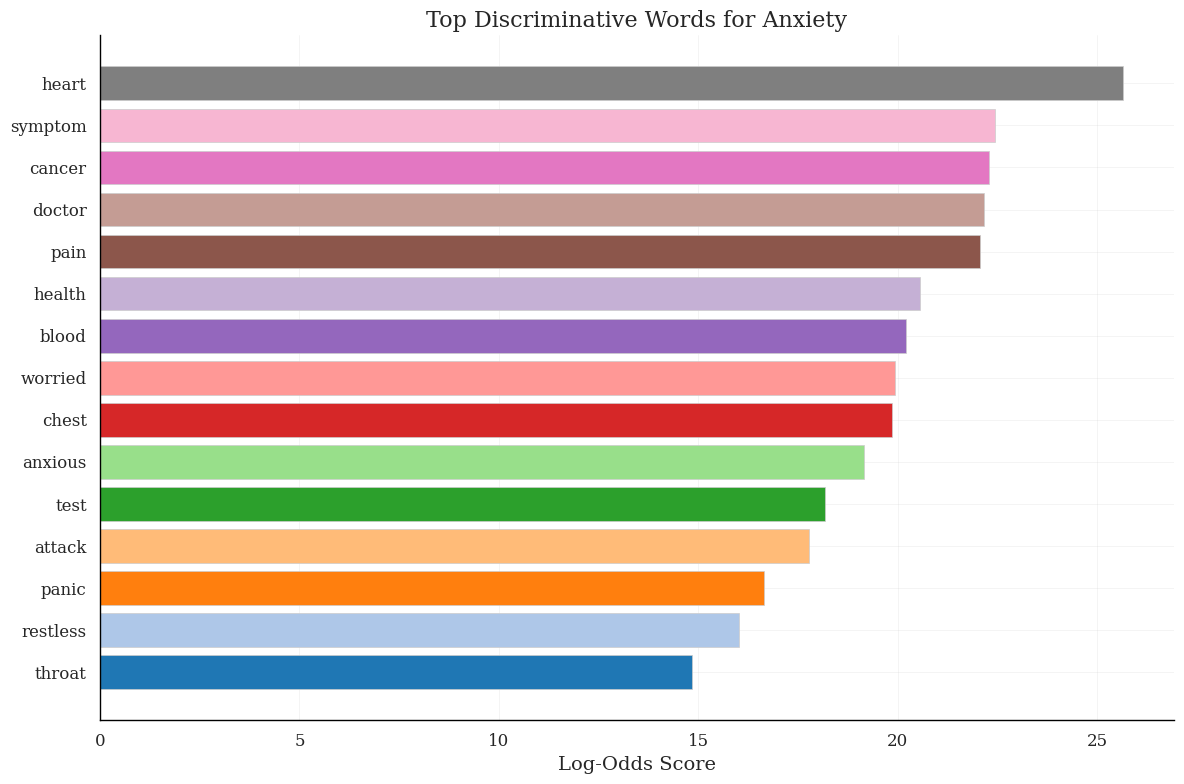

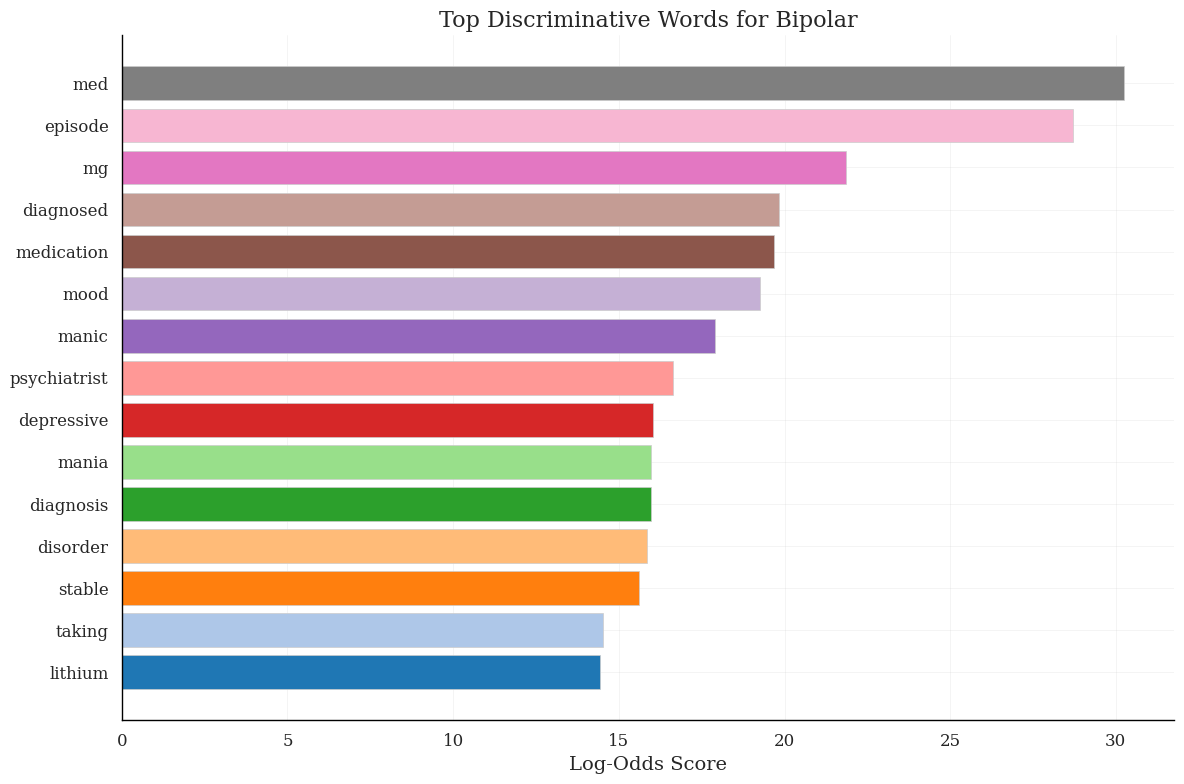

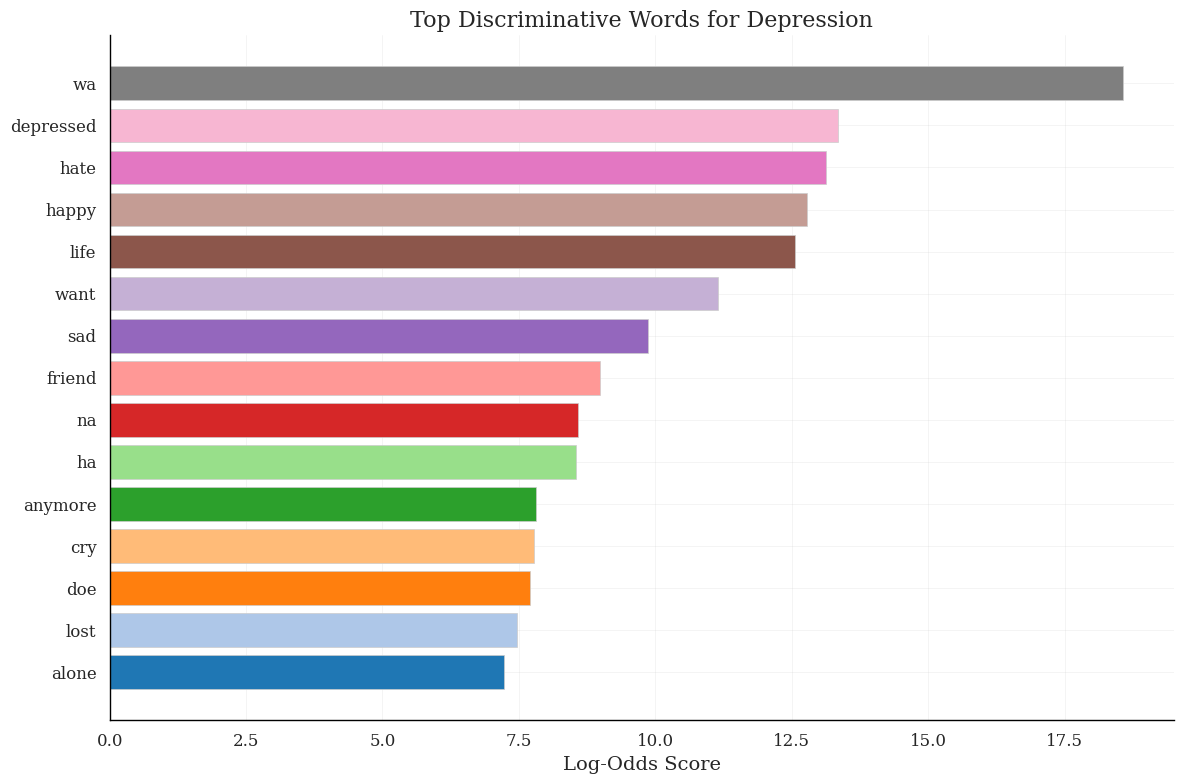

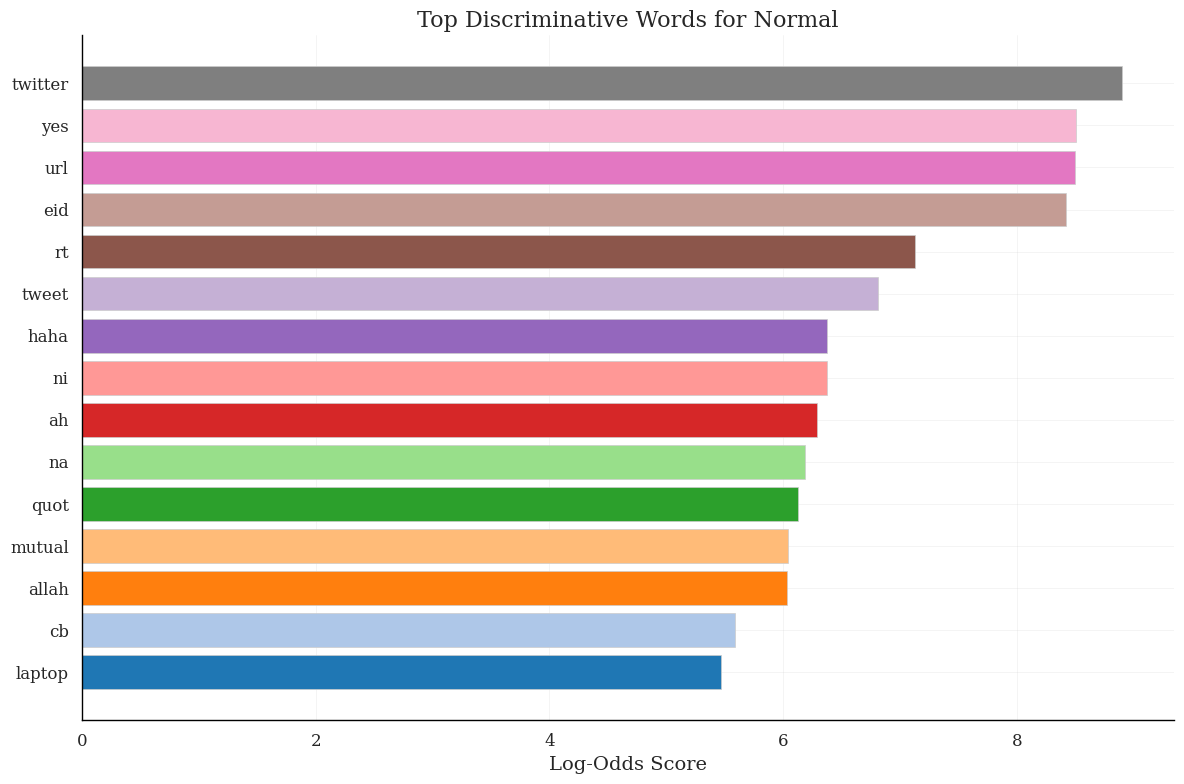

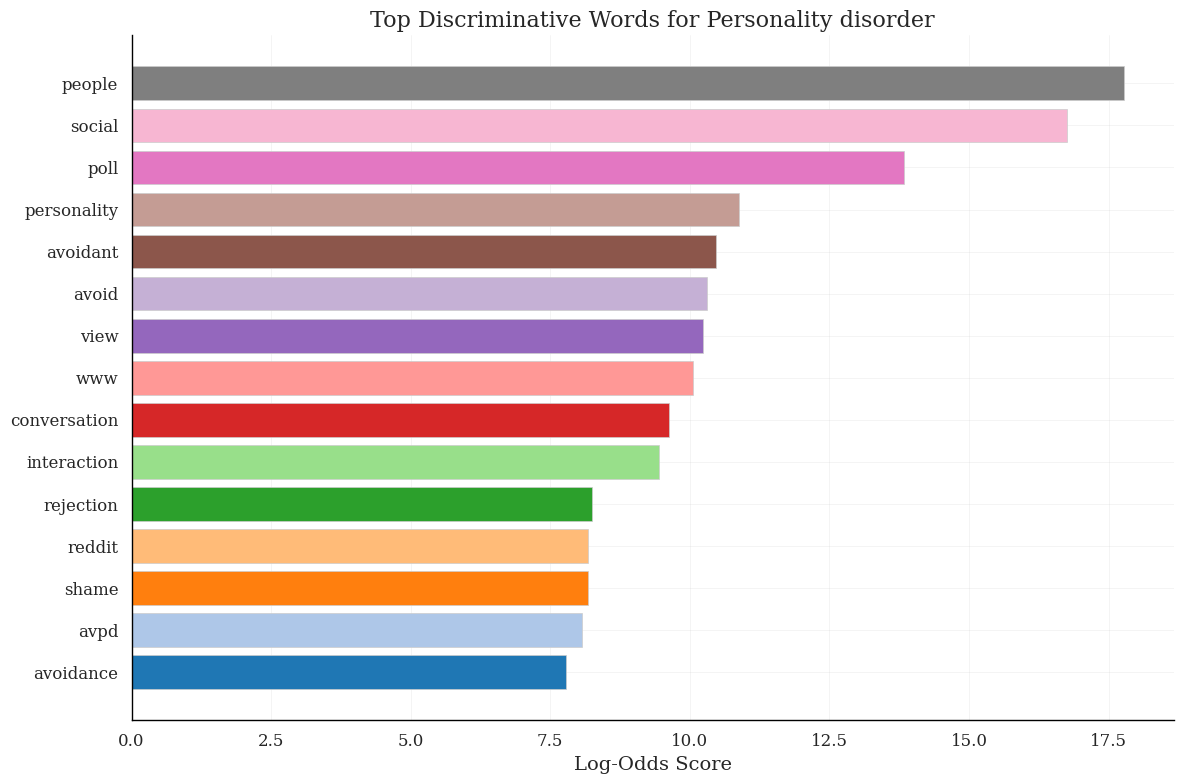

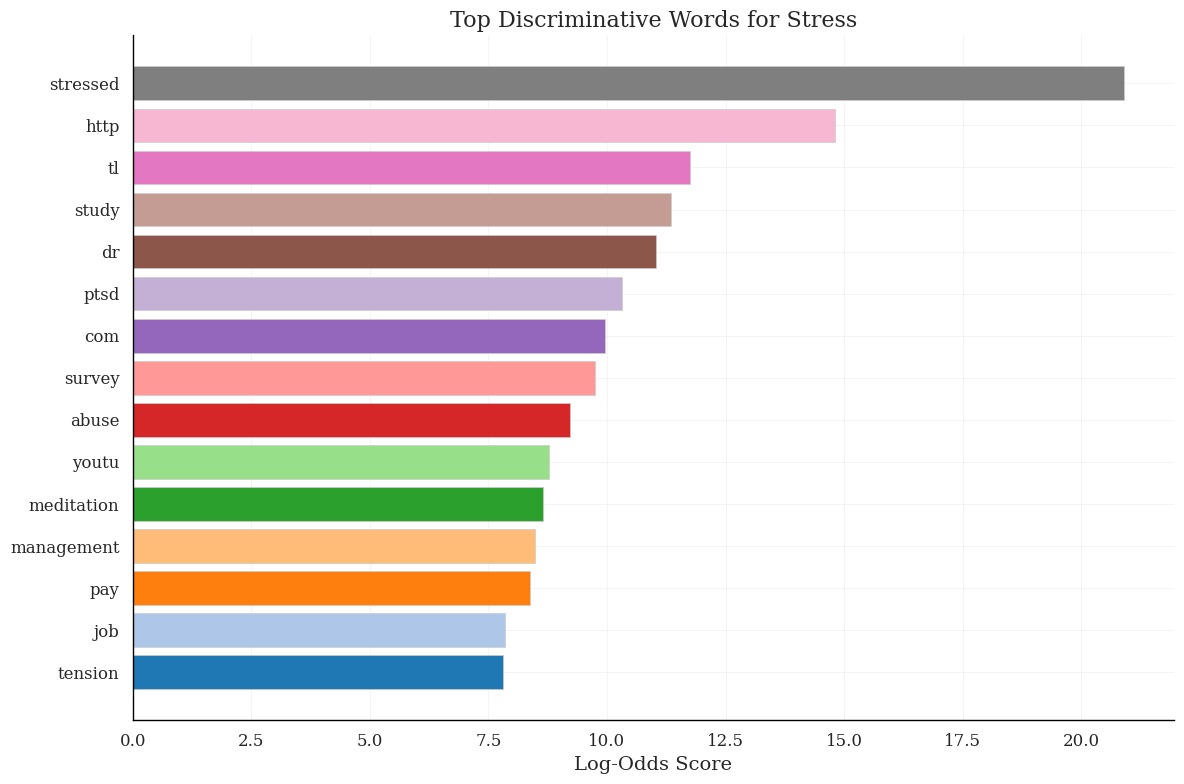

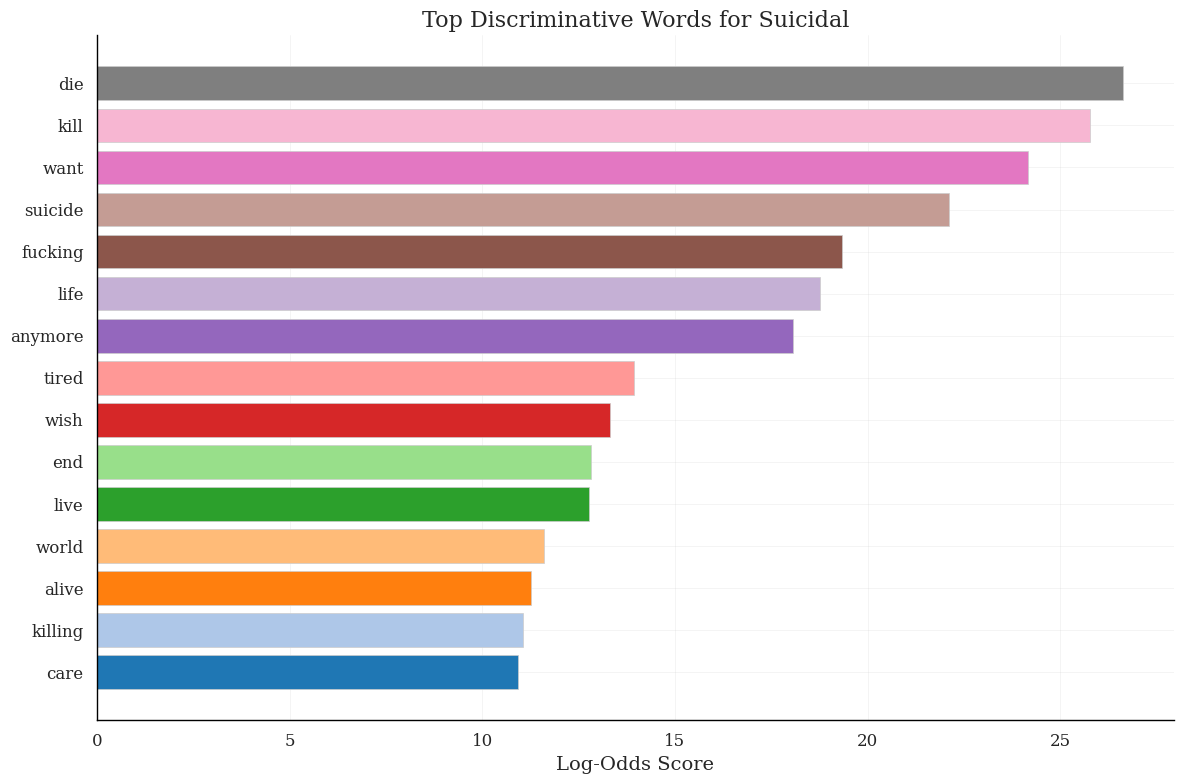

In [36]:
for cls, words in top_keywords.items():
    terms, scores = zip(*words)
    plt.barh(terms[::-1], scores[::-1],color = sns.color_palette("tab20", len(terms)))
    plt.title(f"Top Discriminative Words for {cls}")
    plt.xlabel("Log-Odds Score")
    plt.tight_layout()
    plt.show()


## **Sentiment Polarity Analysis**

Mental health texts aren’t just about topics (keywords) but also about tone.

A sentiment analysis layer helps us measure:

- How negative/positive the language is.

- Which disorders are most negative, neutral, or positive in tone.

I am using VADER (Valence Aware Dictionary and sEntiment Reasoner), it is a lexicon and rule-based sentiment analysis tool specifically designed to analyze sentiment in social media text, though it works on other text types as well. It provides positive, negative, and neutral sentiment scores, along with an overall "compound" score ranging from -1 to +1, with -1 being highly negative and +1 being highly positive. 

In [37]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.5 MB/s eta 0:00:00


In [38]:
# from nltk.sentiment import SentimentIntensityAnalyzer

In [39]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [40]:
# analyzer.polarity_scores("I love this product! It's amazing and works perfectly.")

**Let's compute sentiment polarity per statement. This shows how sentiment varies across classes.**

In [41]:
df2['sentiment'] = df2['clean_statement'].map(lambda x:analyzer.polarity_scores(x)['compound'])

In [42]:
df2.head()

statement   status  \
0  Miradry Experience Miradry Experience\n\nGood ...  Anxiety   
1  I have trouble convincing myself that my frien...  Anxiety   
2  So annoyed with myself...health anxiety resurg...  Anxiety   
3  Health Anxiety Discord https://discord.gg/WSDy...  Anxiety   
4  Anxiety at it again over mice this time. What ...  Anxiety   

   statement_length                                    clean_statement  \
0               357  miradry experience miradry experience good mor...   
1               227  trouble convincing friend love brain always te...   
2              1393  annoyed health resurgence hey guy annoyed even...   
3               350  health discord http discord gg wsdyk set expir...   
4              1330  mouse time ease mind health past rabies amoeba...   

   sentiment  
0     0.8390  
1     0.8934  
2    -0.8555  
3     0.2023  
4     0.9652

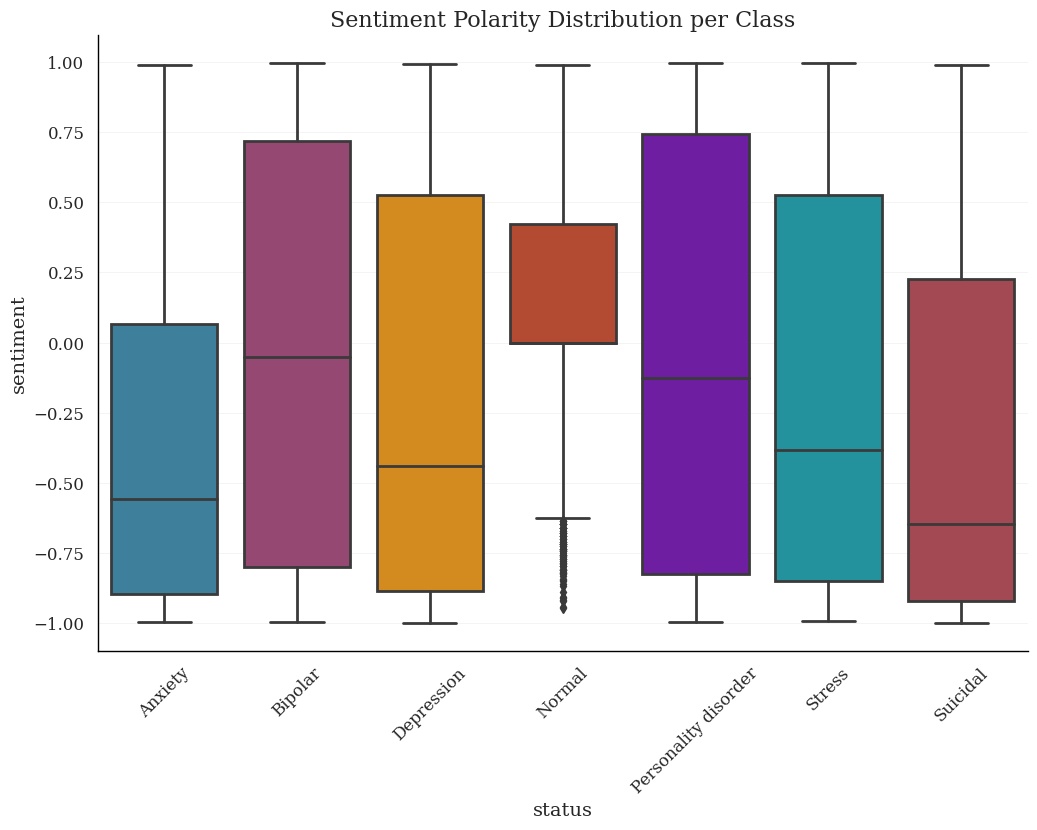

In [43]:
sns.boxplot(x='status', y='sentiment', data=df2)
plt.title("Sentiment Polarity Distribution per Class")
plt.xticks(rotation=45)
plt.show()


The boxplot illustrates how sentiment polarity varies across different mental health statuses. The "Normal" group mostly shows positive or neutral sentiment, suggesting emotional stability, while groups like "Anxiety" and "Depression" trend strongly negative, indicating more negative emotional language. Other categories such as "Bipolar," "Personality disorder," "Stress," and "Suicidal" cover a broad range of sentiment, reflecting emotional variability or instability within these groups.

In [44]:
df2.isnull().sum()

statement           0
status              0
statement_length    0
clean_statement     0
sentiment           0
dtype: int64

### **Average Sentiment per Class**

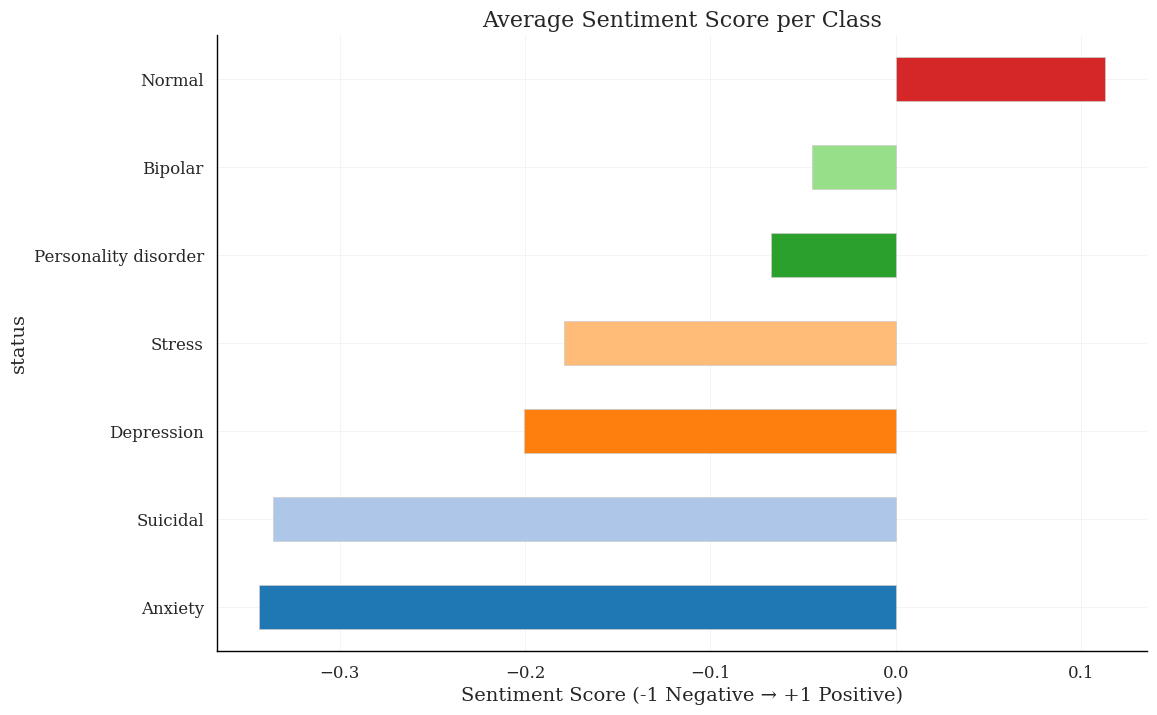

In [45]:
avg_sentiment = df2.groupby("status")['sentiment'].mean().sort_values()
avg_sentiment.plot(kind="barh", color=sns.color_palette("tab20"))
plt.title("Average Sentiment Score per Class")
plt.xlabel("Sentiment Score (-1 Negative → +1 Positive)")
plt.show()


## **Psycholinguistic Analysis**

Raw frequency counts (word clouds, bar charts) tell us what words are common.

Psycholinguistic analysis tells us why people use them → it reflects cognition, emotion, and psychological states.



Let's combining Empath and NRC Emotion Lexicon both:

Psycholinguistic categories (cognition, health, social, etc. from Empath)

Emotional categories (sadness, joy, anger, fear, etc. from NRC)

In [46]:
!pip install empath


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for empath: filename=empath-0.89-py3-none-any.whl size=57799 sha256=2b7aa31c2ea0187a808189a5c70c2f91de0689c557c0e5e8b93e236c978d9702
  Stored in directory: /root/.cache/pip/wheels/b5/93/85/f4e8694df404eb214060dd0e0f3fda14398638f5835b3dde23
Successfully built empath


In [47]:
from empath import Empath
lexicon = Empath()

In [48]:
# lexicon.analyze('regretting holding grudge angry thing passed worrying much future true serenity', normalize=True)

In [49]:
def empath_func(text):
    if isinstance(text, str) and text.strip():
        return lexicon.analyze(text, normalize=True)
    else:
        return {}

In [50]:
empath_scores = df2["clean_statement"].map(empath_func)

In [51]:
df2_empath = pd.DataFrame(list(empath_scores))

In [52]:
df2_empath['status'] = df2['status'].values

In [53]:
empath_means = df2_empath.groupby('status').mean()

In [54]:
empath_means.columns.tolist()

['help',
 'office',
 'dance',
 'money',
 'wedding',
 'domestic_work',
 'sleep',
 'medical_emergency',
 'cold',
 'hate',
 'cheerfulness',
 'aggression',
 'occupation',
 'envy',
 'anticipation',
 'family',
 'vacation',
 'crime',
 'attractive',
 'masculine',
 'prison',
 'health',
 'pride',
 'dispute',
 'nervousness',
 'government',
 'weakness',
 'horror',
 'swearing_terms',
 'leisure',
 'suffering',
 'royalty',
 'wealthy',
 'tourism',
 'furniture',
 'school',
 'magic',
 'beach',
 'journalism',
 'morning',
 'banking',
 'social_media',
 'exercise',
 'night',
 'kill',
 'blue_collar_job',
 'art',
 'ridicule',
 'play',
 'computer',
 'college',
 'optimism',
 'stealing',
 'real_estate',
 'home',
 'divine',
 'sexual',
 'fear',
 'irritability',
 'superhero',
 'business',
 'driving',
 'pet',
 'childish',
 'cooking',
 'exasperation',
 'religion',
 'hipster',
 'internet',
 'surprise',
 'reading',
 'worship',
 'leader',
 'independence',
 'movement',
 'body',
 'noise',
 'eating',
 'medieval',
 'zest',


In [55]:
category_map = {
    "Sadness": ['sadness', 'suffering', 'disappointment', 'torment', 'pain'],
    "Empth_Anxiety": ['nervousness', 'fear', 'timidity', 'confusion'],
    "Health": ['health', 'medical_emergency', 'injury', 'body', 'healing', 'hygiene'],
    "Positive_Emotion": ['joy', 'cheerfulness', 'optimism', 'contentment', 'affection', 'warmth'],
    "Negative_Emotion": ['negative_emotion', 'hate', 'anger', 'rage', 'disgust', 'irritability'],
    "Death": ['death', 'kill', 'suffering', 'torment'],
    "Social": ['social_media', 'family', 'friends', 'communication', 'speaking', 'listen', 'wedding'],
    "Work": ['work', 'occupation', 'school', 'college', 'business', 'programming']
}

In [56]:
scores = {}
for category, cols in category_map.items():
    available_cols = [c for c in cols if c in empath_means.columns]  
    scores[category] = empath_means[available_cols].mean(axis=1)

In [57]:
empath_df = pd.DataFrame(scores)

In [58]:
empath_df

Sadness  Empth_Anxiety    Health  Positive_Emotion  \
status                                                                      
Anxiety               0.020910       0.034714  0.020858          0.008945   
Bipolar               0.012082       0.009211  0.016829          0.007109   
Depression            0.019376       0.009774  0.011922          0.010428   
Normal                0.006118       0.003610  0.005556          0.006913   
Personality disorder  0.013259       0.011069  0.008810          0.007250   
Stress                0.013943       0.010968  0.011362          0.006531   
Suicidal              0.022434       0.007929  0.011884          0.009048   

                      Negative_Emotion     Death    Social      Work  
status                                                                
Anxiety                       0.015925  0.014134  0.008323  0.006183  
Bipolar                       0.011791  0.008878  0.012202  0.010163  
Depression                    0.019256  0.018208  0.015423  0.008450  
Normal                        0.007550  0.004852  0.013821  0.009203  
Personality disorder          0.012688  0.010282  0.018678  0.008712  
Stress                        0.013423  0.011248  0.016397  0.013662  
Suicidal                      0.023436  0.030806  0.014239  0.006227

**Which category dominates for each mental health condition?**

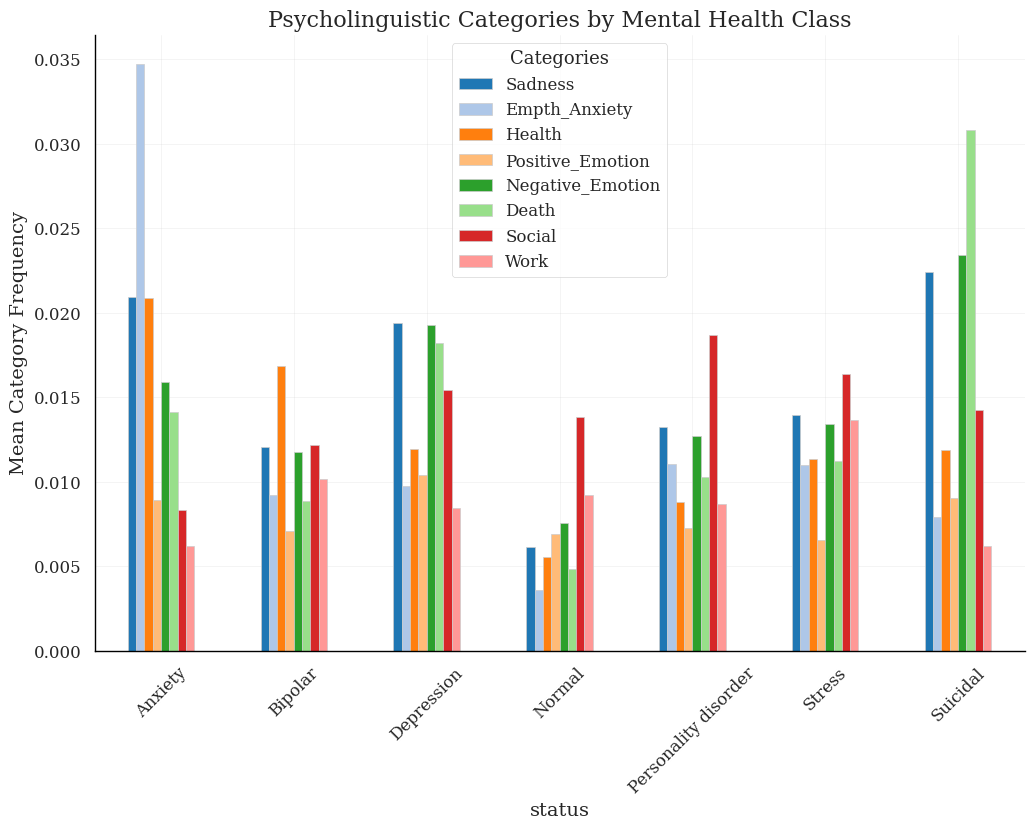

In [59]:
empath_df.plot(kind="bar",color=sns.color_palette("tab20", len(terms)))
plt.title("Psycholinguistic Categories by Mental Health Class")
plt.ylabel("Mean Category Frequency")
plt.xticks(rotation=45)
plt.legend(title="Categories")
plt.show()


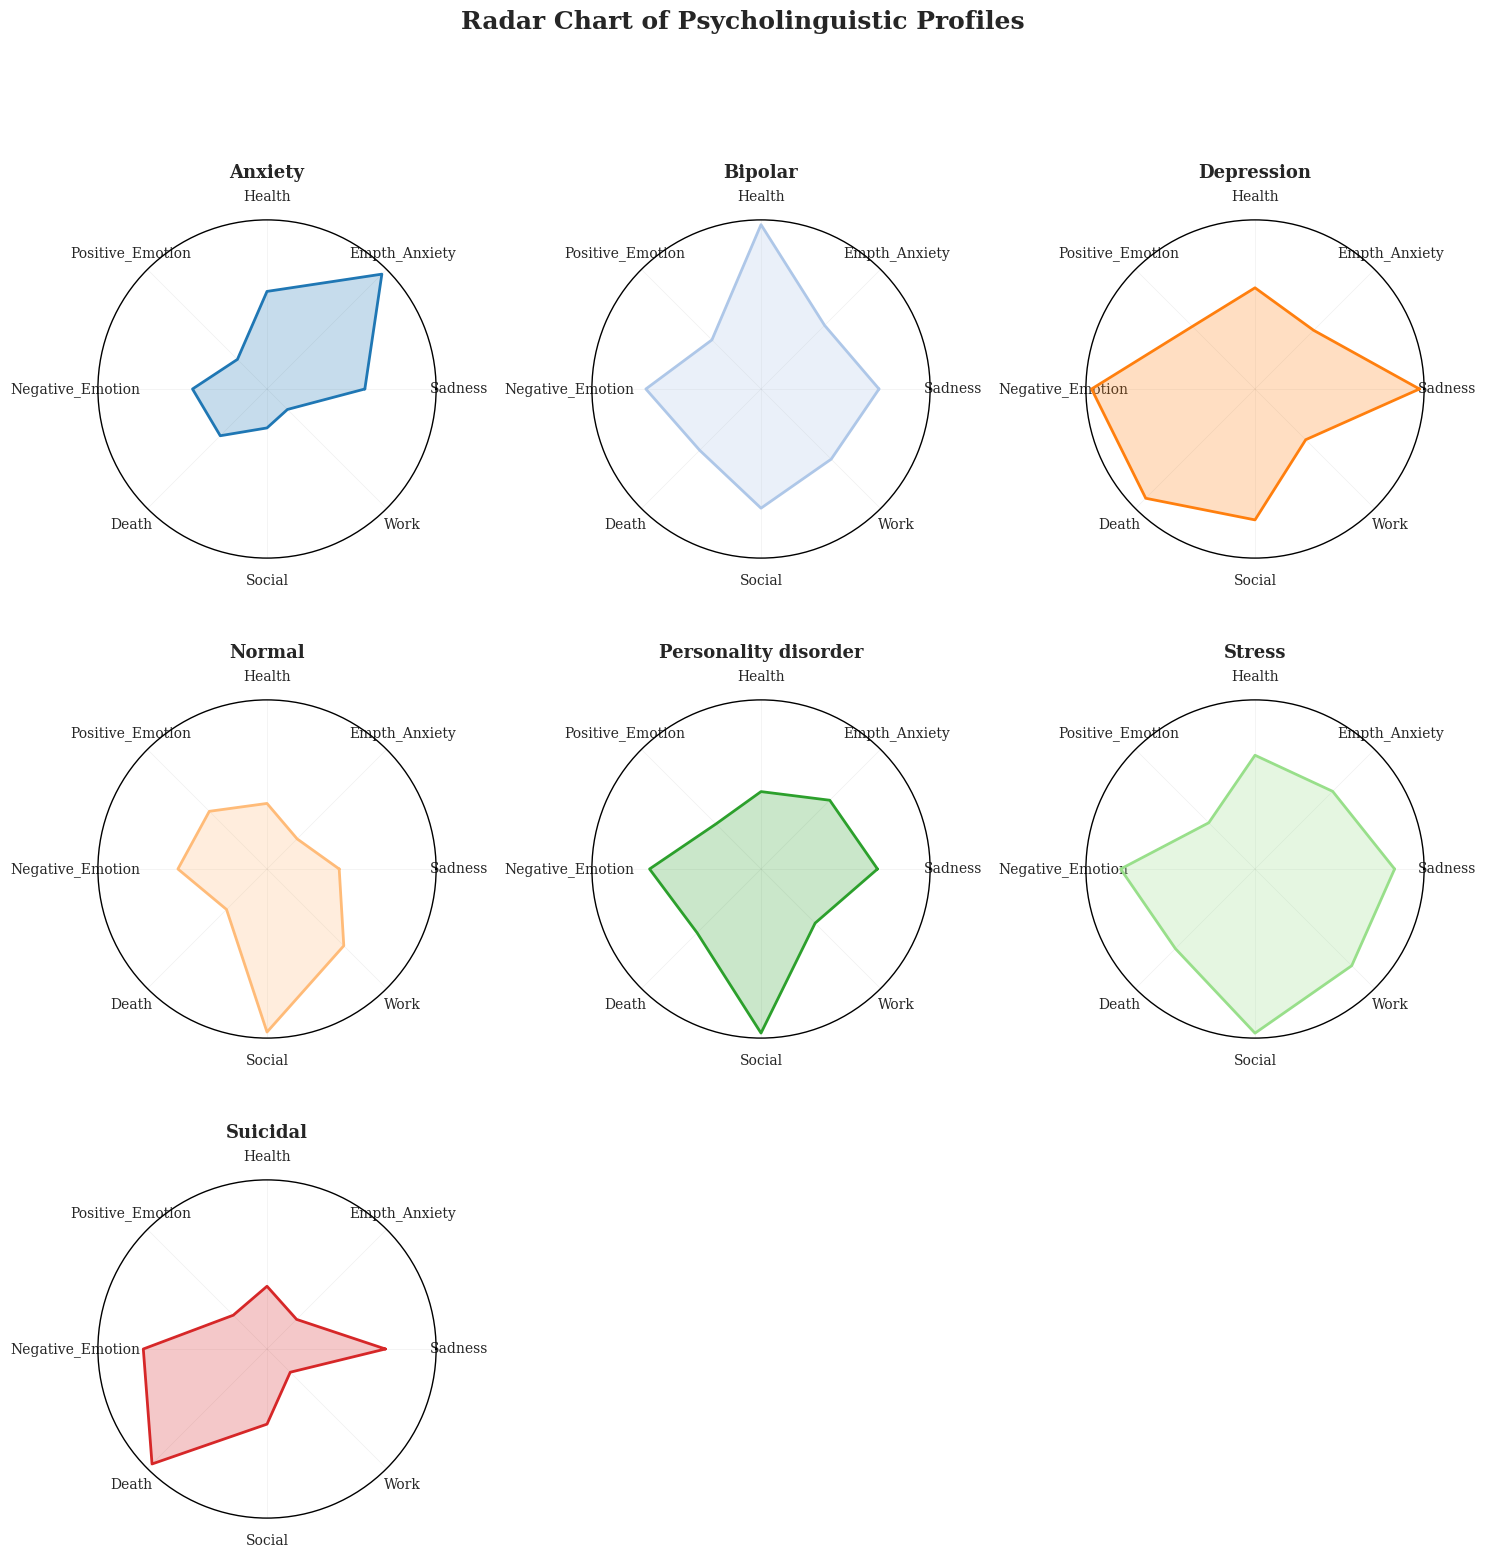

In [60]:
from math import pi

categories = list(empath_df.columns)
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

n_status = len(empath_df.index)
ncols = 3
nrows = -(-n_status // ncols)  

fig, axes = plt.subplots(nrows, ncols, subplot_kw=dict(polar=True), figsize=(15, 5*nrows))
axes = axes.flatten()

colors = plt.cm.tab20.colors  

for i, status in enumerate(empath_df.index):
    values = empath_df.loc[status].values.flatten().tolist()
    values += values[:1]
    
    ax = axes[i]
    ax.plot(angles, values, color=colors[i % len(colors)], linewidth=2)
    ax.fill(angles, values, alpha=0.25, color=colors[i % len(colors)])
    ax.set_title(status, size=13, y=1.1, weight="bold")
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_yticks([])
    ax.grid(True, alpha=0.3, linewidth=0.5)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Radar Chart of Psycholinguistic Profiles", weight="bold", y=1.05)
plt.tight_layout()
plt.show()


In [61]:
!pip install nrclex

INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43309 sha256=320bacbb06da6e8e3c2b76be453d1afcc3ffe00119bb6d9fdffa67eceaa11d1e
  Stored in directory: /root/.cache/pip/wheels/ed/ac/fa/7afddefd14f51c4a963ed291b9052746ed3929473e5a33118d
Successfully built nrclex


In [62]:
from nrclex import NRCLex

In [63]:
NRCLex('regretting holding grudge angry thing passed worrying much future true serenity').raw_emotion_scores

{'negative': 4,
 'sadness': 2,
 'anger': 2,
 'disgust': 1,
 'anticipation': 2,
 'fear': 1,
 'joy': 2,
 'positive': 2,
 'trust': 2}

In [64]:
def get_nrc_scores(text):
    text = str(text).strip()
    if not text:
        return {}
    nrc_obj = NRCLex(text)
    return nrc_obj.raw_emotion_scores  

In [65]:
nrc_scores = df2["clean_statement"].apply(get_nrc_scores)

In [66]:
nrc_scores

0        {'anticipation': 2, 'joy': 2, 'positive': 3, '...
1        {'trust': 4, 'joy': 2, 'positive': 3, 'anger':...
2        {'surprise': 2, 'negative': 18, 'sadness': 7, ...
3        {'anger': 6, 'disgust': 5, 'negative': 7, 'sad...
4        {'anticipation': 3, 'positive': 8, 'negative':...
                               ...                        
12785    {'positive': 3, 'trust': 2, 'negative': 1, 'an...
12786    {'anger': 1, 'disgust': 1, 'fear': 2, 'negativ...
12787    {'positive': 5, 'fear': 2, 'negative': 4, 'sad...
12788    {'anticipation': 5, 'disgust': 2, 'joy': 8, 'p...
12789    {'anticipation': 3, 'joy': 4, 'positive': 6, '...
Name: clean_statement, Length: 12790, dtype: object

In [67]:
nrc_df = pd.DataFrame(list(nrc_scores))

In [68]:
nrc_df['status'] = df2['status'].values

In [69]:
nrc_means = nrc_df.groupby('status').mean()

In [70]:
nrc_means

anticipation       joy  positive  surprise     trust  \
status                                                                       
Anxiety                   3.451573  2.446738  4.596723  2.131731  3.600413   
Bipolar                   3.971193  3.146214  5.805794  2.238278  4.109840   
Depression                3.920986  3.529332  5.756041  2.224456  4.004981   
Normal                    1.619760  1.594059  2.026559  1.246154  1.766823   
Personality disorder      3.959565  3.757774  6.553221  2.310345  4.430882   
Stress                    3.000000  2.533099  4.597200  1.828112  3.238663   
Suicidal                  3.638070  3.105720  4.850638  2.053980  3.387053   

                          fear   disgust  negative   sadness     anger  
status                                                                  
Anxiety               4.759524  3.074592  7.076754  4.154568  3.227642  
Bipolar               3.998207  2.593890  6.046070  3.794997  3.043214  
Depression            4.102968  3.003554  6.312534  4.450737  3.440154  
Normal                1.454762  1.255521  1.624646  1.382289  1.341333  
Personality disorder  3.998469  2.860735  6.077247  4.063005  3.192377  
Stress                3.023559  2.177742  4.662500  2.981595  2.585150  
Suicidal              4.183449  2.901269  6.081301  4.421777  3.403152

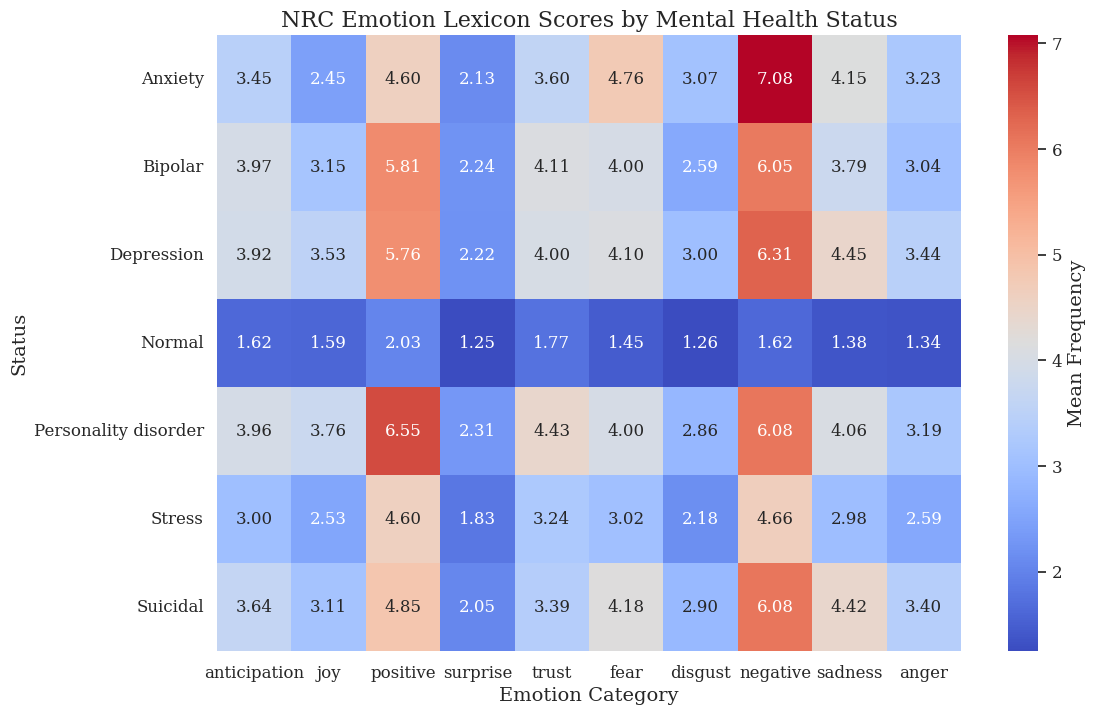

In [71]:
sns.heatmap(nrc_means, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={'label': 'Mean Frequency'})
plt.title("NRC Emotion Lexicon Scores by Mental Health Status")
plt.ylabel("Status")
plt.xlabel("Emotion Category")
plt.show()


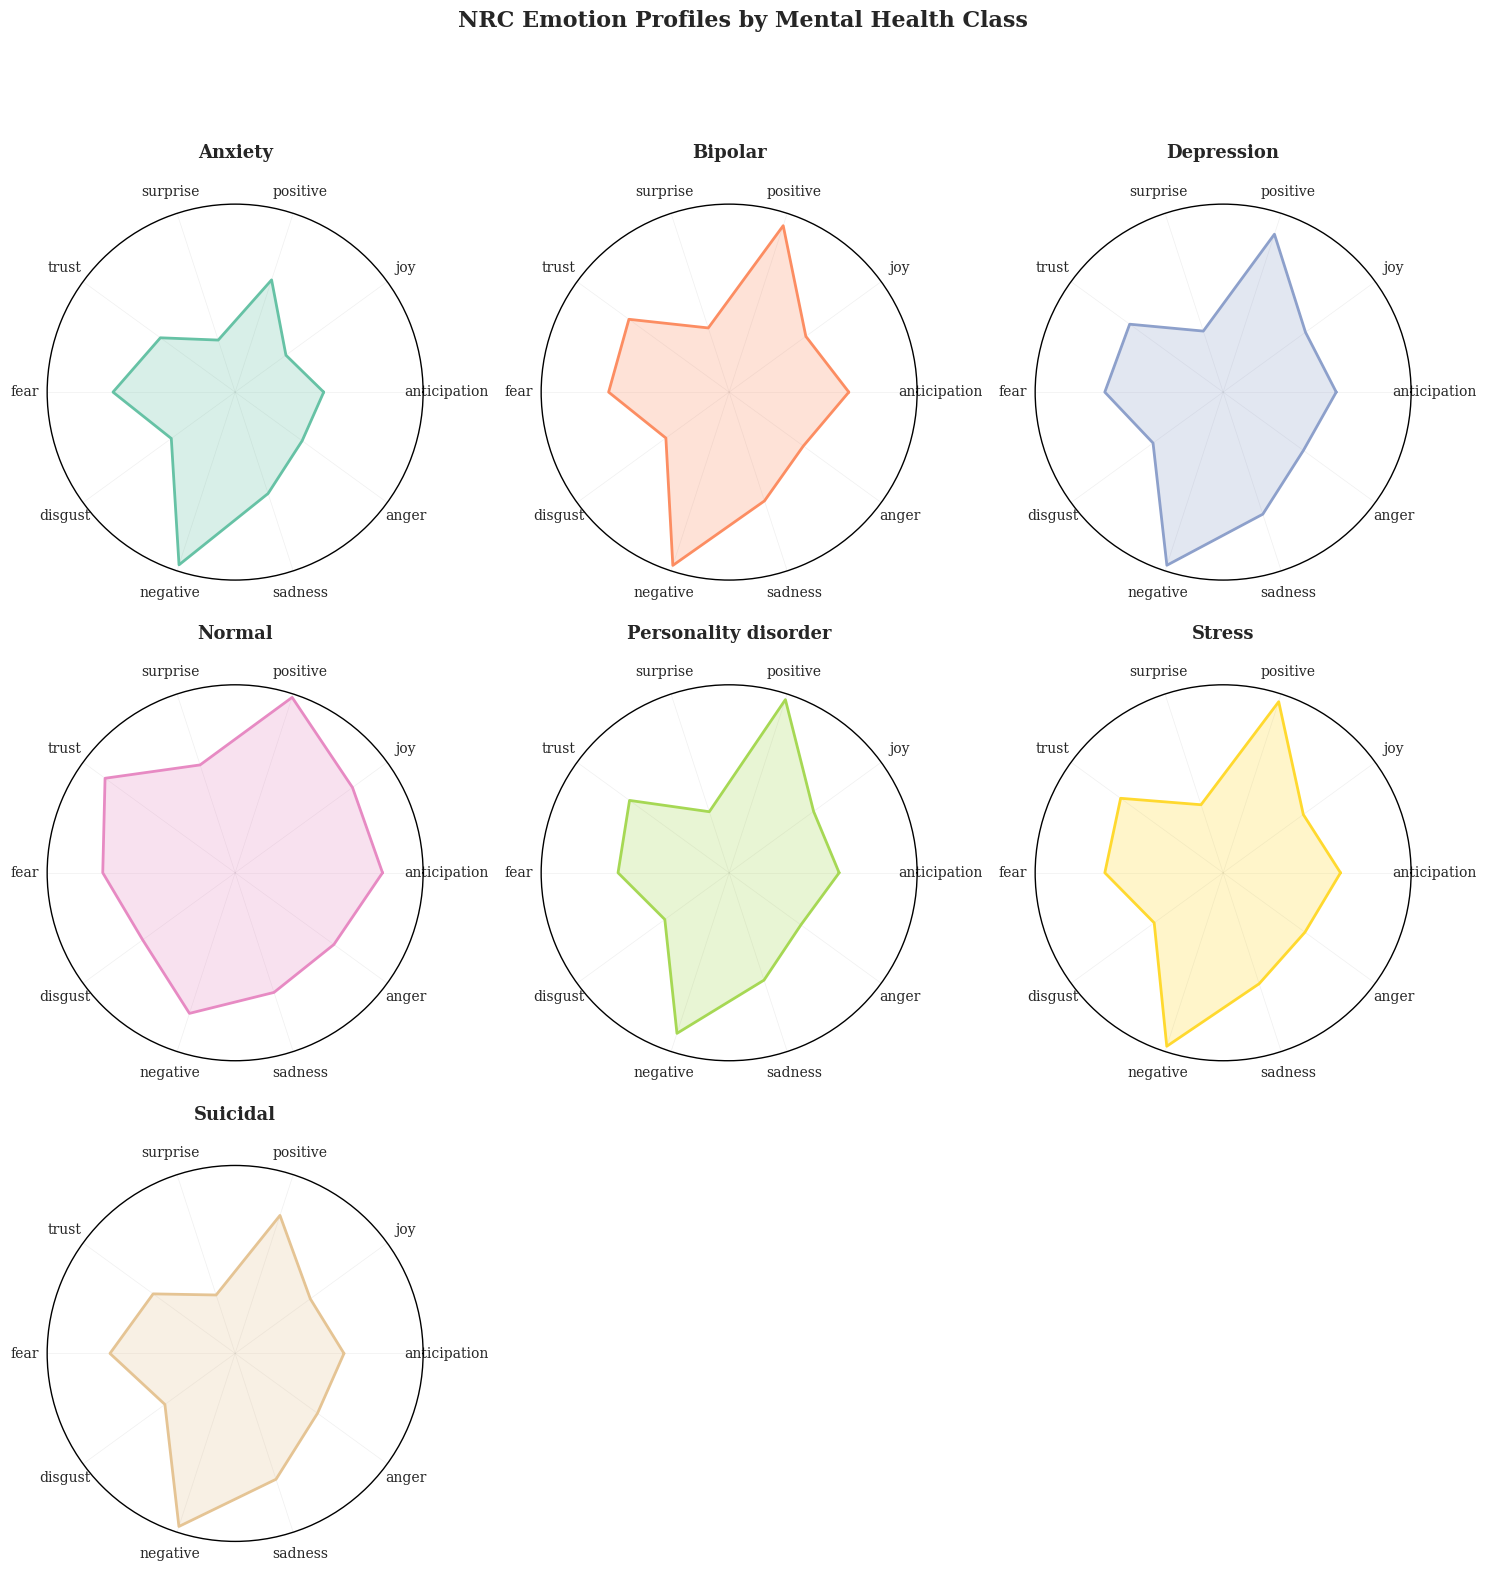

In [72]:
categories = list(nrc_means.columns)
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

n_status = len(nrc_means.index)
ncols = 3
nrows = -(-n_status // ncols) 

fig, axes = plt.subplots(nrows, ncols, subplot_kw=dict(polar=True), figsize=(15, 5*nrows))
axes = axes.flatten()

colors = plt.cm.Set2.colors  

for i, status in enumerate(nrc_means.index):
    values = nrc_means.loc[status].values.flatten().tolist()
    values += values[:1]
    
    ax = axes[i]
    ax.plot(angles, values, color=colors[i % len(colors)], linewidth=2)
    ax.fill(angles, values, alpha=0.25, color=colors[i % len(colors)])
    ax.set_title(status, size=13, y=1.1, weight="bold")
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_yticks([])
    ax.grid(True, alpha=0.3, linewidth=0.5)

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("NRC Emotion Profiles by Mental Health Class", fontsize=16, weight="bold", y=1.05)
plt.tight_layout()
plt.show()


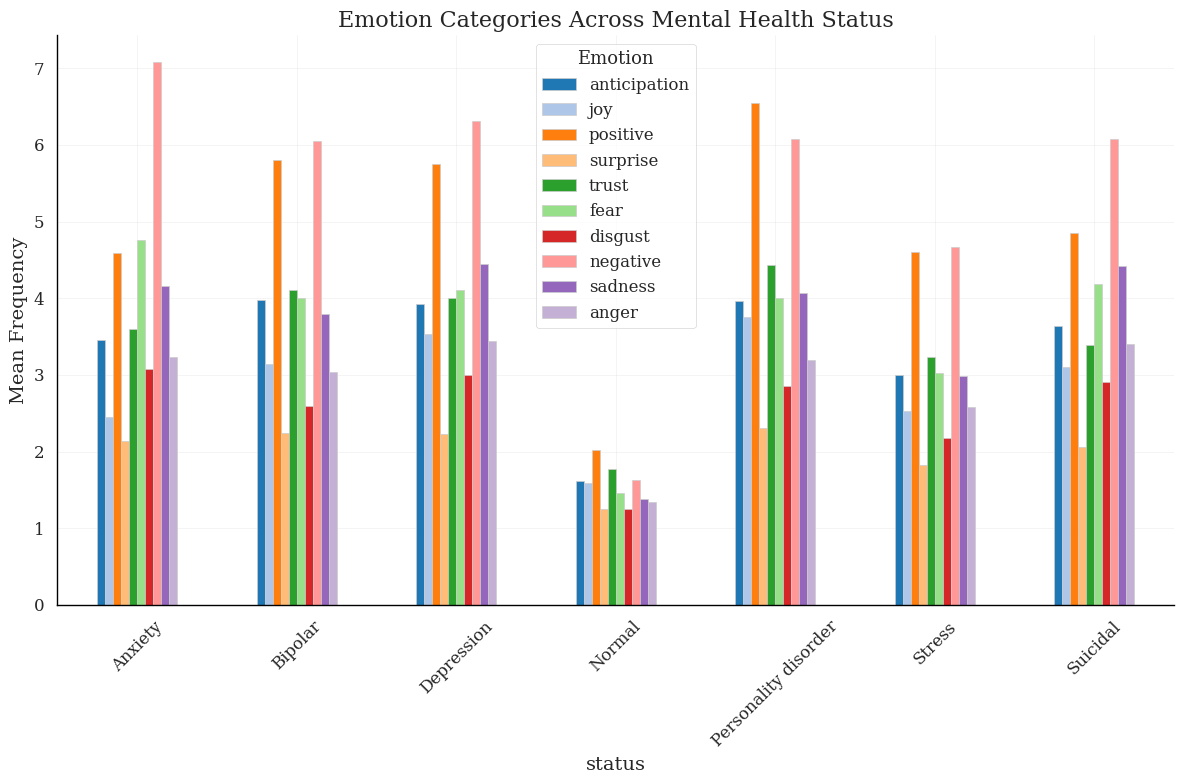

In [73]:
nrc_means.plot(kind="bar",color=sns.color_palette("tab20"))
plt.title("Emotion Categories Across Mental Health Status")
plt.ylabel("Mean Frequency")
plt.xticks(rotation=45)
plt.legend(title="Emotion")
plt.tight_layout()
plt.show()


*If you found this notebook helpful or insightful, please consider upvoting it! Your support motivates me to create more valuable content and helps others discover it too. Thank you!*